In [ ]:
import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter, ResampleFilter, MorletWaveletFilter
import xarray as xarray
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
from scipy.stats import zscore
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1' 'RepFR1'

In [2]:
subs = ['R1035M'] #['R1108J'] # R1065J # 'R1035M'

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
193,NaN,protocols/r1/subjects/R1035M/experiments/catFR...,protocols/r1/subjects/R1035M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1035M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1035M/localizations/0/m...,NaN,0,R1035M,R1035M,NaN,protocols/r1/subjects/R1035M/experiments/catFR...


In [3]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[4:7]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(521, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,NaN,protocols/r1/subjects/R1626S/experiments/catFR...,protocols/r1/subjects/R1626S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1626S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1626S/localizations/0/m...,NaN,3,R1626S,R1626S,3.4,protocols/r1/subjects/R1626S/experiments/catFR...
2658,NaN,protocols/r1/subjects/R1626S/experiments/catFR...,protocols/r1/subjects/R1626S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1626S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1626S/localizations/0/m...,NaN,4,R1626S,R1626S,3.4,protocols/r1/subjects/R1626S/experiments/catFR...
2659,NaN,protocols/r1/subjects/R1626S/experiments/catFR...,protocols/r1/subjects/R1626S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1626S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1626S/localizations/0/m...,NaN,6,R1626S,R1626S,3.4,protocols/r1/subjects/R1626S/experiments/catFR...
2661,NaN,NaN,protocols/r1/subjects/R1627T/localizations/0/m...,catFR1,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1627T/localizations/0/m...,NaN,0,R1627T,R1627T,4.0,protocols/r1/subjects/R1627T/experiments/catFR...


# Load from Cluster Run in SWRanalysis main program

In [4]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'encoding'
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
#               NOTE: this analysis is in SWRanalysis-encoding.ipynb now
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

recall_type_switch = 0

recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # TEMPORALLOBE # IFG # MFG # ENTPHC # AMY
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; HFA_array = []
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'-NOCUTOFFS.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
                        # -NOCUTOFFS for Vaz filter for Norman/Staresina comparison
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array'])
            HFA_array = superVstack(HFA_array,dat['HFA_array'])
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            elif selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
                session_events = session_events.append(dat['session_events']) # doesn't append in place 
            elif selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array'])
                               
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                rectime_array.extend(dat['rectime_array'])
                recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])
            elif selected_period == 'whole_encoding':
                serialpos_array.extend(dat['serialpos_array']); recall_position_array.extend(dat['recall_position_array'])
                list_recall_num_array.extend(dat['list_recall_num_array']); 

            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>=0
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
    temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
    encoded_word_key_array.extend(dat['encoded_word_key_array'])
elif selected_period == 'whole_encoding':
    temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
elif selected_period == 'encoding':
    temp_recall_idxs = np.ones(len(session_name_array))==1 # just keep them all
    session_events = session_events[temp_recall_idxs]
    
    # spread out encoded_word_key too so I know which words were correct
    word_correct_array = []
    for sess_elec in encoded_word_key_array:
        word_correct_array.append(sess_elec)
    word_correct_array = np.array(word_correct_array)
    word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects
    
subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
session_name_array = np.array(session_name_array)[temp_recall_idxs]
electrode_array = np.array(electrode_array)[temp_recall_idxs]
channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
ripple_array = np.array(ripple_array)[temp_recall_idxs]
HFA_array = np.array(HFA_array)[temp_recall_idxs]

if exp == 'surrounding_recall':
    rectime_array = np.array(rectime_array)[temp_recall_idxs]
    list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
    recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all HPC subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for FR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for FR1
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)


[]
[]
2022-08-31_13-49-21: DF Exception: Sub: R1004D, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1004D_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-4-3dd4e29db93c>, line no: 57
2022-08-31_13-49-23: DF Exception: Sub: R1067P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1067P_1_HPC_encoding_soz_in_hamming.p', file: <ipython-input-4-3dd4e29db93c>, line no: 57
2022-08-31_13-49-26: DF Exception: Sub: R1147P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1147P_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-4-3dd4e29db93c>, line no: 57
2022-08-31_13-49-28: DF Exception: Sub: R1190P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1190P_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-4-3dd4e29db93c>, li

88.97058823529412

% of HPC recalls for catFR1


491.4990110482888

(246010, 1500)

From 243/254 sessions with >0 HPC electrodes
Total trials: 246010
Unique sessions: 243
...from 121 patients
Number of electrodes: 598
Electrode regions X sessions:
219 for  left hippocampus
180 for  right hippocampus
285 for "ca1"
140 for "dg"
34 for "sub"
118 for left ca1
3 for left ca2
6 for left ca3
76 for left dg
271 for left hippocampus
30 for left sub
103 for right ca1
41 for right dg
186 for right hippocampus
17 for right sub


In [39]:
# these should all be the same length!
len(ripple_array)
len(electrode_array)
len(list_num_key)
# len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(session_name_array)
len(HFA_array)

13068

13068

13068

0

13068

13068

13068

13068

## Get start array

In [5]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# gotta translate this to new frame as well from idxs in load step if selected subfield
if select_subfield == True: 
    location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
# if selected_period in ['surrounding_recall','math','math_retrieval']:
#     list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
#     rectime_array = np.array(rectime_array)[updated_recalls]
if selected_period == 'surrounding_recall':
    list_num_key = list_num_key[updated_recalls]
if selected_period == 'encoding':
    word_correct_array = word_correct_array[updated_recalls]
    serialpos_array = np.array(serialpos_array)[updated_recalls]
#     session_events = session_events[updated_recalls]

HFA_array = HFA_array[updated_recalls,:]
    
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]


Total electrodes loaded: 1310
from 243 sessions from 121 subjects with trial nums:
[120. 120. 120. 120. 120. 120. 120. 300. 300. 156. 156. 156. 156. 156.
 156. 156. 156. 216. 216. 216.]
Trial sum = 246010.0
['left sub', 'left ca1', 'left ca1', 'left sub', 'left ca1', 'left dg', 'left ca1', 'left ca3', 'left ca1', 'left ca1', 'left sub', 'left sub', 'left ca1', 'right ca1', 'right ca1', 'right ca1', 'right ca1', 'left ca1', 'left sub', 'left sub']
Number of sub_sess names: 1310
Got start_array with 99683 trials!


In [12]:
len(word_correct_array)
len(serialpos_array)
len(HFA_array)

28365

28365

28365

# Retrieval PVTHs

In [10]:
%autoreload
import warnings

# make a PSTH based on start times of SWRs
bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

# HFA
PSTH = triangleSmooth(np.mean(HFA_array,0),smoothing_triangle)

# get binned start array (trials X bins)
if pad > 0:
    binned_start_array = HFA_array[:,pad:-pad] # remove edge bins
print('done making binned start_array with shape:')
binned_start_array.shape

# # get trial X 1 categorical names for subjects and sessions # do this in start_array cell now
# if select_ordinal_position == 0: # if 0 already did this in last cell
#     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

# note that output is the net ± distance from mean
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  
    SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
print('SEs created!')

# should all be same length! (sanity check)
print('Are these three the same length?? They should be!')
binned_start_array.shape
len(subject_name_array)
len(session_name_array)

done making binned start_array with shape:


(13380, 26)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
Are these three the same length?? They should be!


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(13380, 26)

13380

13380

In [11]:
# let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
stats_bin = 5 # time bin width in ms to test stats on

psth_start = -20
psth_end = 20
first_start = -16 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -1
second_start = 2 # same idea
second_end = 17
sr_factor = 1 # already at 100 ms resolution with these bins

start_array.shape
binned_first_stats_array = HFA_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
binned_second_stats_array = HFA_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
print('done binning start_arrays'); binned_start_array.shape

bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
# bin_model1.summary()
# bin_model2.summary()

(13380, 1500)

done binning start_arrays


(13380, 26)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


IndexError: index 2 is out of bounds for axis 1 with size 2

ValueError: x and y must have same first dimension, but have shapes (36,) and (26,)

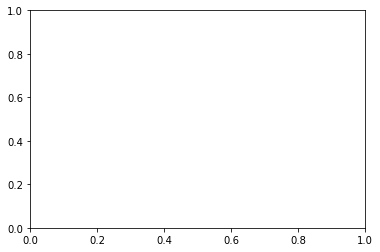

In [12]:
## plot PSTH and save data for plot (see SWRplots)

save_plot_data = 0

plot_sig_bars = 0

bin_centers = np.arange(psth_start+0.5,psth_end)
subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- SE
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
if selected_period == 'surrounding_recall':
    xlabel('Time from recall (ms)')
elif selected_period == 'math_retrieval':    
    xlabel('Time from response (s)')
elif selected_period == 'math':
    xlabel('Time from problem onset (s)')
ylabel('HFA (z-score)')
# title('Mean of ripples for '+exp)
# tight_layout()
hlines(0,psth_start,psth_end,color=(0.3,0.3,0.3))
ax = plt.gca()

ax.set_ylim(-0.6,0.6)
ax.set_xlim(psth_start-1,psth_end+1)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]
xticks(np.arange(psth_start,psth_end+0.01,stats_bin),np.arange(psth_start*100,psth_end*100+1,stats_bin*100))

# plot bands of significance
if plot_sig_bars == 1:
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
num_trials = start_array.shape[0]


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'-HFA.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p' #'-ANLIPLOT.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' recalls')

if save_plot_data == 1:
    # get strings for path name for save and loading cluster data

    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH':PSTH,'SE_plot':SE_plot,'num_trials':num_trials,
                    'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_first_stats_array':binned_first_stats_array,'binned_second_stats_array':binned_second_stats_array,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array}, f)
a=1;

# Encoding PSTHs

done making binned start_array with shape:
(37316, 30)
SEs created!
done making binned start_array with shape:
(62367, 30)
SEs created!


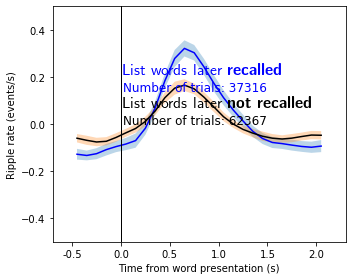

In [6]:
plot_ME_mean = 1 # 0 for typical PSTH, 1 for ME mean, 2 for average across sub averages
save_plot_data = 0

ytextshift = 0

%autoreload
import warnings
# get PSTH for recalled and then forgotten words. 
# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700]

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?


# set up the PVTH stats parameters here too (for encoding have 30 bins)

psth_start = int(pre_encoding_time/bin_size)
psth_end = int(encoding_time/bin_size)
sr_factor = 1 # already at 100 ms resolution with these bins

bin_centers = np.arange(psth_start+0.5,psth_end)
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# get vectors of encoding list identifier data for forgotten and recalled words
# in encoded_word_key_array, 0 for not recalled, 1 for recalled, 2 for recalled but was an IRI<2 (don't care about that for encoding)

start_array_enc_forgot = HFA_array[word_correct_array==0]
start_array_enc_recalled = HFA_array[word_correct_array==1]

# same for sub and sess
sub_forgot = np.array(subject_name_array)[word_correct_array==0]
sess_forgot = np.array(session_name_array)[word_correct_array==0]
sub_recalled = np.array(subject_name_array)[word_correct_array==1]
sess_recalled = np.array(session_name_array)[word_correct_array==1]


# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        sub_name_array = sub_recalled
        sess_name_array = sess_recalled
        
        # for plot
        subplots(1,1,figsize=(5,4))
        label = 'List words later \\textbf{recalled}'
        plot_color = (0,0,1)
        text(.250,0.21-ytextshift,label,usetex=True,size=16,color=plot_color)
        text(.250,0.14-ytextshift,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)

    else:       
        temp_start_array = start_array_enc_forgot
        sub_name_array = sub_forgot
        sess_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{not recalled}'        
        plot_color = (0,0,0)
        text(.250,0.07-ytextshift,label,usetex=True,size=16,color=plot_color) 
        text(.250,0.00-ytextshift,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
        
    # HFA 
    PSTH = triangleSmooth(np.mean(temp_start_array,0),smoothing_triangle)

    print('done making binned start_array with shape:')
    print(temp_start_array.shape)

    # note that output is the net ± distance from mean
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")    
        mean_plot,SE_plot = getMixedEffectMeanSEs(temp_start_array,sub_name_array,sess_name_array)
    print('SEs created!')
    
    if plot_ME_mean == 1:
        PSTH = triangleSmooth(mean_plot,smoothing_triangle) # replace PSTH with means from ME model (after smoothing as usual)  
    elif plot_ME_mean == 2:
        temp_means = []
        for sub in np.unique(sub_name_array):
            temp_means = superVstack(temp_means,np.mean(temp_start_array[np.array(sub_name_array)==sub],0))
        PSTH = triangleSmooth(np.mean(temp_means,0),smoothing_triangle)
        SE_sub_level = np.std(temp_means,0)/np.sqrt(len(temp_means))     
    
    ## plot ##
    
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    if pad > 0:
        xr = xr[pad:-pad]
        binned_start_array = temp_start_array[:,pad:-pad] # remove edge bins    
        PSTH = PSTH[pad:-pad]
        SE_plot = SE_plot[:,pad:-pad]        
    
    plot(xr,PSTH,color=plot_color)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500)/100,
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ax.set_ylim(-0.5,0.5)
    ax.set_xlim(pre_encoding_time/100,encoding_time/100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
    if category == 0:
        PSTH_recalled = copy(PSTH)
        SE_recalled = copy(SE_plot)
    else:
        PSTH_forgotten = copy(PSTH)
        SE_forgotten = copy(SE_plot)    
a=1;

In [57]:
# now that we have the plot with SEs, do stats on key bins. Note here just looking at single bins but comparing across categories

for test in range(2):
    if test == 0:
        first_start = int(ripple_bin_start_end[0]/bin_size)
        first_end = int(ripple_bin_start_end[1]/bin_size)
    else:
        first_start = int(1700/bin_size) # same idea but for post-encoding period (ILI)
        first_end = int(2300/bin_size)
        
    bin_test_range = range(int( ((first_start-pre_encoding_time/bin_size)/sr_factor) ),
                           int( ((first_end-pre_encoding_time/bin_size)/sr_factor) ))
    binned_recalled_array = start_array_enc_recalled[:,bin_test_range]
    binned_forgot_array = start_array_enc_forgot[:,bin_test_range]
    
    stats_bin = int(first_end-first_start)
    binned_recalled_array = binBinaryArray(binned_recalled_array,stats_bin,sr_factor) # should be creating vectors for both
    binned_forgot_array = binBinaryArray(binned_forgot_array,stats_bin,sr_factor)
    
    bin_model1 = []; bin_model2 = []
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore")
#         bin_model = MEstatsAcrossCategories(binned_recalled_array,binned_forgot_array,
#                                         sub_forgot,sess_forgot,sub_recalled,sess_recalled)
    
# #         # plot bands of significance
# #     if bin_model.pvalues[1] < 0.05:
# #         plot([first_end-stats_bin,first_end],[0.5,0.5],color=(1,0.5,0))
    
#     if test == 0:
#         bin_model1 = copy(bin_model)
#         binned_recalled_array1 = copy(binned_recalled_array)
#         binned_forgot_array1 = copy(binned_forgot_array)
#     else:
#         bin_model2 = copy(bin_model)
#         binned_recalled_array2 = copy(binned_recalled_array)
#         binned_forgot_array2 = copy(binned_forgot_array)
# print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
# print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

num_trials = len(word_correct_array) 


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'-HFA.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print(str(num_trials)+' trials')    
        
if save_plot_data == 1:
    # get strings for path name for save and loading cluster data
            
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH_recalled':PSTH_recalled,'PSTH_forgotten':PSTH_forgotten,
                    'SE_recalled':SE_recalled,'SE_forgotten':SE_forgotten,'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_recalled_array1':binned_recalled_array1,'binned_forgot_array1':binned_forgot_array1,
                    'binned_recalled_array2':binned_recalled_array2,'binned_forgot_array2':binned_forgot_array2,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array,
                    'word_correct_array':word_correct_array}, f) 
        # word_correct_array is indicator for subsequently remembered and forgotten. Can get num_trials from it too
a=1;

/home1/john/SWR/figures/ENCODING/SWR_catFR1_AMY__0_soz_in_hamming_whole-HFA.p
42519 trials


In [ ]:
# SME model

import statsmodels.formula.api as smf

pre_encoding_time = -700
ripple_bin_start_end = [100,1700] #[100,1700] #[400,1100] # [100,1700]
sr_factor = 2
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/bin_size),
                       int((-pre_encoding_time+ripple_bin_start_end[1])/bin_size)) 
SME_df = pd.DataFrame({'HFA':np.mean(HFA_array[:,encoding_range],1),
                       'correct':word_correct_array,'session':session_name_array,'subject':subject_name_array})
vc = {'session':'0+session'}
SME_model = smf.mixedlm("HFA ~ correct", SME_df, groups="subject", vc_formula=vc,re_formula="correct")
SME_results = SME_model.fit(reml=True, method='nm',maxiter=2000) 
print(SME_results.summary())
print('**p-values**:'); print(SME_results.pvalues)
print('**coefs**:'); print(SME_results.params)
print('**SEs**:'); print(SME_results.bse_fe)

## just to remake plot

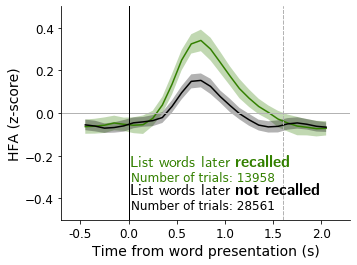

In [59]:
save_plot = 1

subplots(1,1,figsize=(5,3.75))

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        sub_name_array = sub_recalled
        sess_name_array = sess_recalled
        
        # for plot
        label = 'List words later \\textbf{recalled}'
        ytextshift = 0
        if location_selected == 'ca1':
            plot_color = (0,0,1)
            ytextshift = 0.45
        elif location_selected == 'dg':
            plot_color = (1,0,0)
            ytextshift = 0.45
        elif region_name == 'ENT':
            plot_color = (0.5,0.5,0)
            ytextshift = 0.45
        elif region_name == 'PHC':
            plot_color = (0,0.5,0.5)
            ytextshift = 0.05
        elif region_name == 'AMY':
            plot_color = (0.2,0.5,0)
            ytextshift = 0.45
        elif region_name == 'ENTPHC':
            plot_color = (0.5,0.2,0)
            ytextshift = 0.45           
        text(.250,0.2-ytextshift,label,usetex=True,size=16,color=plot_color)
        text(.250,0.13-ytextshift,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
        
        PSTH = copy(PSTH_recalled)
        SE_plot = copy(SE_recalled)

    else:       
        temp_start_array = start_array_enc_forgot
        sub_name_array = sub_forgot
        sess_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{not recalled}'        
        plot_color = (0,0,0)
        text(.250,0.07-ytextshift,label,usetex=True,size=16,color=plot_color) 
        text(.250,0.00-ytextshift,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
        
        PSTH = copy(PSTH_forgotten)
        SE_plot = copy(SE_forgotten)
        
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    PSTH = PSTH; #boot_SD = boot_SD[pad:-pad]
    plot(xr,PSTH,color=plot_color)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], facecolor=plot_color, alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500)/100,
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)',fontsize=14)
    ylabel('HFA (z-score)',fontsize=14)
    tight_layout()
    ax = plt.gca()
    ax.set_ylim(-0.5,0.5)
    ax.set_xlim(pre_encoding_time/100,encoding_time/100)
    plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0,0],linewidth=1,linestyle='-',color=(0.7,0.7,0.7))
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([16.00,16.00],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))

xticks(fontsize=12)
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)    

if save_plot == 1:
    
    path_name = '/home1/john/SWR/figures/ENCODING/'
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+'_'+soz_label+\
                      '_'+filter_type+'_'+sub_selection+'-HFA'+'_'+str(plot_ME_mean)+'.pdf') 
    plt.savefig(fn,transparent=True)

a=1;

# HFA by serialpos

In [123]:
## plot recalled events by serial position

bin_size = 100 # in ms
pre_encoding_time = -700
ripple_bin_start_end = [400,1100]
first_start = int(ripple_bin_start_end[0]/bin_size)
first_end = int(ripple_bin_start_end[1]/bin_size)
bin_test_range = range(int( ((first_start-pre_encoding_time/bin_size)) ),
                       int( ((first_end-pre_encoding_time/bin_size)) ))

ct = 0
serial_position_rem_rates = []
serial_position_rem_stds = []
serial_position_forgot_rates = []
serial_position_forgot_stds = []
num_recalled = []; num_forgot = []

for list_num in range(12):
    temp_HFA_array_rem = HFA_array[((word_correct_array==1) & (np.array(serialpos_array)==(list_num+1)))]
    temp_HFA_array_forgot = HFA_array[(word_correct_array==0) & (np.array(serialpos_array)==(list_num+1))]

    # save data for full serial position plot below
    serial_position_rem_rates.append(np.mean(temp_HFA_array_rem[:,bin_test_range]))
    serial_position_rem_stds.append(np.std(temp_HFA_array_rem[:,bin_test_range])/np.sqrt(len(temp_HFA_array_rem)))
    serial_position_forgot_rates.append(np.mean(temp_HFA_array_forgot[:,bin_test_range]))
    serial_position_forgot_stds.append(np.std(temp_HFA_array_forgot[:,bin_test_range])/np.sqrt(len(temp_HFA_array_forgot)))
    num_recalled.append(temp_HFA_array_rem.shape[0])
    num_forgot.append(temp_HFA_array_forgot.shape[0])   
a=1;

Number in each bin: 5736


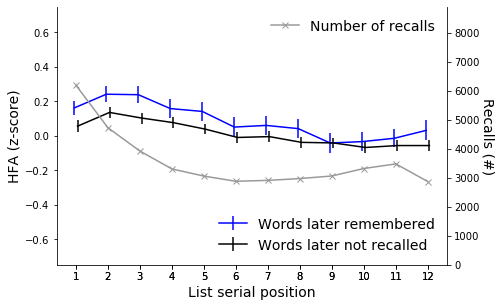

In [124]:
# create the general figure
fig1 = figure(figsize=(7,4.75))
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)

xr=np.arange(1,13)

if location_selected == 'ca1':
    plot_color = (0,0,1)
    ytextshift = 0.45
elif location_selected == 'dg':
    plot_color = (1,0,0)
    ytextshift = 0.45
elif region_name == 'AMY':
    plot_color = (0.2,0.5,0)
    ytextshift = 0.45
elif region_name == 'ENTPHC':
    plot_color = (0.5,0.2,0)
    ytextshift = 0.45  
line1 = errorbar(xr-0.05,serial_position_rem_rates,serial_position_rem_stds,color=plot_color) 
line2 = errorbar(xr+0.05,serial_position_forgot_rates,serial_position_forgot_stds,color=(0,0,0))
xticks(xr,xr)
ax1.set_ylim(-0.75,0.75)
xlabel('List serial position',size=14)
ylabel('HFA (z-score)',size=14)
# if bin_range_to_compare == range(10,20):
#     title('Ripple rate 100-1700 ms after word presentation')
# elif bin_range_to_compare == range(24,29): 
#     title('Ripple rate 1700-2200 ms after word presentation')
    
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line3 = ax2.plot(xr,num_recalled, 'xr-',color=(0.6,0.6,0.6))
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
if region_name == 'HPC':
    ax2.set_ylim(0,8900)
else:
    ax2.set_ylim(0,4000)
ylabel("Recalls (#)",rotation=270,size=14)
ax2.yaxis.set_label_coords(1.12,0.5)

ax1.legend((line1,line2),("Words later remembered","Words later not recalled"),frameon=False,fontsize=14,loc='lower right')
if (exp == 'catFR1'):
    ax2.legend(line3,{"Number \nof recalls"},loc='upper right',frameon=False,fontsize=14)
else:
    ax2.legend(line3,{"Number of recalls"},loc='upper right',frameon=False,fontsize=14)    

# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
# legend((line1, line2), ("1", "2"))
ax1.spines['top'].set_visible(False)   
print('Number in each bin: '+str(len(temp_HFA_array_rem)+len(temp_HFA_array_rem)))
show();